In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
import cvxpy as cp

## Group Assignment
### Team Number: 08
### Team Member Names: Abbas, Gurmehar, Elaine
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


In [4]:
# tickers_file_name = "Tickers_Example.csv"
# tickers_file_original = pd.read_csv(tickers_file_path , header = None, names=['Ticker'])
tickers_file_path = "Tickers_Example.csv"
tickers_file_original = pd.read_csv(tickers_file_path , header = None, names=['Ticker'])

start_date = "2023-10-01"
end_date = "2024-09-30"
drop_tickers = []


# clearning function to get rid of invalid tickers
for tick in tickers_file_original['Ticker']:    

    try:
        ticker = yf.Ticker(tick) 

        # drop ticker if it is not a stock
        if ticker.info['quoteType'] != 'EQUITY':
            drop_tickers.append(tick)
            continue
            
        # drop ticker if it is not US/Canada based
        if ticker.fast_info.get('currency') not in ['USD', 'CAD']:
            drop_tickers.append(tick)
            continue

        history = ticker.history(start = start_date, end = end_date)

        trading_days = history['Volume'].resample('ME').count()
        volume = history['Volume'].resample('ME').sum()
        trading_days = trading_days[trading_days>=18]
        volume = volume[volume.index==trading_days.index]
        monthly_volume = volume.mean()

        # drop stock if monthly volumn is less than 100k
        if monthly_volume<100000: 
            drop_tickers.append(tick)

    except:
            drop_tickers.append(tick)
            pass
    
tickers_file_original.drop(tickers_file_original[tickers_file_original["Ticker"].isin(drop_tickers)].index, inplace=True)
tickers_file_original = tickers_file_original.drop_duplicates(subset=['Ticker'], keep='last')
tickers_file_original = tickers_file_original.reset_index(drop=True)
tickers_file_original.index = tickers_file_original.index + 1

In [5]:
# take exchange rates from yfinance
exchange = 'USDCAD=X'
exchange_ticker = yf.Ticker(exchange)
exchange_rate = exchange_ticker.history(interval = '1mo', start=start_date, end=end_date)["Close"]
exchange_rate = pd.DataFrame(exchange_rate)
exchange_rate.index = exchange_rate.index.date
exchange_rate_value = exchange_rate.mean().iloc[0]

In [6]:
# take historical prices of market indices and calculate returns
sp500 = yf.Ticker("^GSPC").history(start=start_date, end=end_date)['Close'].mul(exchange_rate_value)
sp500.index = sp500.index.date
sp500_return = sp500.pct_change().dropna()

tsx60 = yf.Ticker("XIU.TO").history(start=start_date, end=end_date)['Close']
tsx60.index = tsx60.index.date
tsx60_return = tsx60.pct_change().dropna()

total_investment = 1000000

# Calculating what the million of dollars would be at the end if it was invested in the market indices
sp500val = (total_investment / sp500.iloc[0]) * sp500.iloc[-1]
sp500val = round(sp500val,2)

tsx60val = (total_investment / tsx60.iloc[0]) * tsx60.iloc[-1]
tsx60val = round(tsx60val,2)

average = (sp500val + tsx60val) / 2
average = round(average,2)

common_dates = sp500_return.index.intersection(tsx60_return.index)

average_df = pd.DataFrame(data = {"% Return" : (sp500_return.loc[common_dates] + tsx60_return.loc[common_dates])/2}, index = common_dates)

In [7]:
# intialize dataframes
stocks = {key: 0 for key in tickers_file_original['Ticker'].values}
current_data = pd.DataFrame()
metrics = pd.DataFrame(index=list(stocks.keys()), columns=['SP-beta','SP-corr','TSX-beta','TSX-corr', 'Volatility', 'S&P500', 'TSX60'])

# scrap data from websites to find tickers in the S&P 500
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_df = pd.read_html(url)[0]
sp500companies = sp500_df.Symbol.tolist()


# list of TSX companies retrieved from the web
tsx60companies = ["RY.TO", "TD.TO", "SHOP.TO", "ENB.TO", "CNR.TO", "SU.TO", "BN.TO", "CSU.TO", 
    "MFC.TO", "TRP.TO", "BMO.TO", "BNS.TO", "ATD.TO", "ABX.TO", "BCE.TO", "CM.TO", 
    "CP.TO", "NTR.TO", "TRI.TO", "WCN.TO", "MG.TO", "L.TO", "IFC.TO", "WN.TO", 
    "SLF.TO", "FNV.TO", "TECK.B.TO", "DOL.TO", "OTEX.TO", "FM.TO", "IMO.TO", 
    "CVE.TO", "PPL.TO", "CNQ.TO", "FTS.TO", "H.TO", "RCI.B.TO", "T.TO", "AQN.TO", 
    "SAP.TO", "MRU.TO", "QSR.TO", "WPM.TO", "POW.TO", "EMA.TO", "AEM.TO", 
    "GIL.TO", "GIB.A.TO", "TOU.TO", "BEP.UN.TO", "BIP.UN.TO", "CTC.A.TO", 
    "CCL.B.TO", "K.TO", "WSP.TO", "IFP.TO"]


# functions to check if a stock is in the market indices, if so, add 2 to their points
def in_sp500(ticker, sp500companies):
    if ticker in sp500companies:
        return 2
    else:
        return 0
    
def in_tsx60(ticker, tsx60companies):
    if ticker in tsx60companies:
        return 2
    else:
        return 0


# calculate returns for market indices
sp500_returns = sp500.pct_change(fill_method=None)
tsx60_returns = tsx60.pct_change(fill_method=None)


# loop through the stock list and calculate volatility, check if it is either indices, calculate beta and correlation 
for i in stocks:
    try:
        current_data[i] = yf.Ticker(i).history(start=start_date, end=end_date)["Close"]
        volatility = current_data[i].std(axis=0)
        metrics.loc[i, 'Volatility'] = volatility
        metrics.loc[i, 'S&P500'] = in_sp500(i, sp500companies)
        metrics.loc[i, 'TSX60'] = in_tsx60(i, tsx60companies)

        # calculate return rates of the stock
        stock_returns = current_data[i].pct_change().dropna()
        stock_returns.index = stock_returns.index.date

        # find date indices that are present in both the stock returns and index returns
        common_dates = stock_returns.index.intersection(sp500_returns.index).intersection(tsx60_returns.index)

        # align data so that they have the same amoutn fo data points
        stock_returns = stock_returns.loc[common_dates]
        aligned_sp500_returns = sp500_returns.loc[common_dates]
        aligned_tsx60_returns = tsx60_returns.loc[common_dates]

        # calculate beta with respect to S&P 500
        covariance = np.cov(stock_returns, aligned_sp500_returns)[0, 1]
        variance = np.var(aligned_sp500_returns)
        beta_sp500 = covariance / variance

        # calculate correlation coefficient with respect to S&P 500
        correlation_sp500 = np.corrcoef(stock_returns, aligned_sp500_returns)[0, 1]

        # calculate beta with respect to TSX 60
        covariance_tsx = np.cov(stock_returns, aligned_tsx60_returns)[0, 1]
        variance_tsx = np.var(aligned_tsx60_returns)
        beta_tsx60 = covariance_tsx / variance_tsx

        # calculate correlation coefficient with respect to TSX 60
        correlation_tsx60 = np.corrcoef(stock_returns, aligned_tsx60_returns)[0, 1]

        # update values to dataframe
        metrics.loc[i, 'SP-corr'] = correlation_sp500
        metrics.loc[i, 'SP-beta'] = beta_sp500
        metrics.loc[i, 'TSX-corr'] = correlation_tsx60
        metrics.loc[i, 'TSX-beta'] = beta_tsx60

        # update another dataframe
        stocks[i] = round(5 * (2 * correlation_sp500 + 0.6 * (abs (1 - beta_sp500)) + 0.6 * (abs (1 - beta_tsx60)) + 2 * correlation_tsx60) 
                        + metrics.loc[i, 'S&P500'] + metrics.loc[i, 'TSX60'] - (0.05 * volatility),2)
    except:
        continue

/var/folders/x9/sh1tpp6n3qn3yp3kqlj160qc0000gn/T/ipykernel_98728/2391953025.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = current_data[i].pct_change().dropna()
/var/folders/x9/sh1tpp6n3qn3yp3kqlj160qc0000gn/T/ipykernel_98728/2391953025.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = current_data[i].pct_change().dropna()
/var/folders/x9/sh1tpp6n3qn3yp3kqlj160qc0000gn/T/ipykernel_98728/2391953025.py:52: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading N

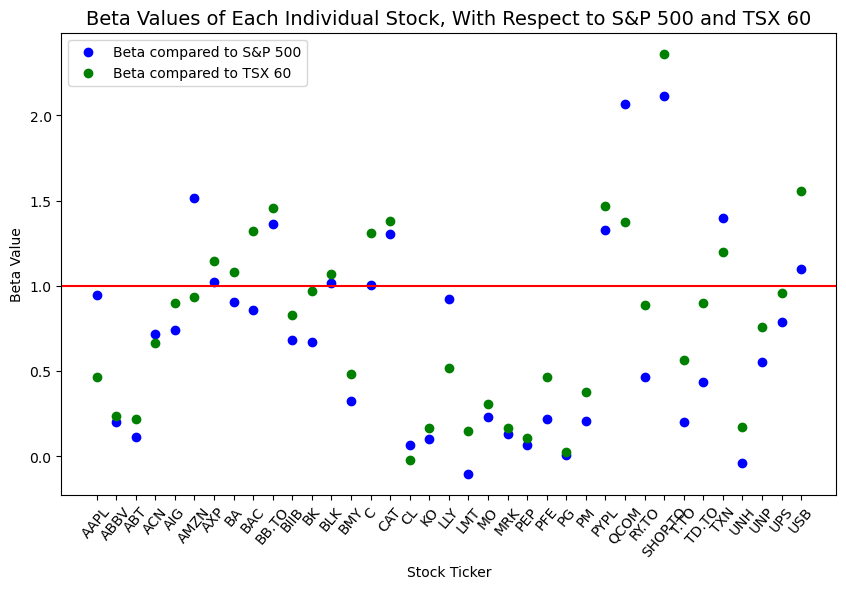

In [8]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation = 50)
plt.axhline(y=1, color = 'red')
plt.scatter(metrics.index, metrics['SP-beta'], label='Beta compared to S&P 500', color='blue')
plt.scatter(metrics.index, metrics['TSX-beta'], label='Beta compared to TSX 60', color = 'green')
plt.ylabel("Beta Value")
plt.xlabel("Stock Ticker")

plt.title("Beta Values of Each Individual Stock, With Respect to S&P 500 and TSX 60", fontsize=14)
plt.legend(loc="upper left", fontsize=10)  

plt.show()

The above is our analysis of each stock's beta values with respect to both market indices. We took stocks with beta values closest to 1. 

In [10]:
# sort stocks based on their points
stocks = dict(sorted(stocks.items(), key=lambda item: item[1], reverse=True))
stocks = list(stocks.items())[:24]
stocks = dict(stocks)

In [11]:
# assign weights to reduce difference from portfolio to market 

def give_weight(num_stocks):
    stocks_now = list(stocks.keys())[:num_stocks]
    
    # Retrieve the initial and final prices for the selected stocks
    prices = np.array(current_data[stocks_now].iloc[0])
    last_values = np.array(current_data[stocks_now].iloc[-1])
    w = cp.Variable(num_stocks)
    # Calculate the portfolio value given the weights, scaled to $1,000,000
    my_value = cp.sum(cp.multiply(last_values, w * 1000000 / prices))
    min_weight = (100 / (2 * num_stocks)) / 100
    # define optimization goal: minimize different from market
    objective = cp.Minimize(my_value - sp500val)

    # constraints such as the sum of weight, minimal weight, maximum weight
    constraints = [
        cp.sum(w) == 1,           
        w >= min_weight,                    
        w <= 0.15                      
    ]

    # syntax of the cvxpy library
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [12]:
# calculate the portfolio value given weights and a subset of stocks
def get_value(weights,i):
    last_row = current_data[list(stocks.keys())[:i]].iloc[-1]
    first_row = current_data[list(stocks.keys())[:i]].iloc[0]
    return np.sum(np.multiply(last_row,np.divide(weights*1000000,first_row)))

In [13]:
# calculate portfolio value and weights
def stocks_ith_portfolio(numStocks):
    weight_now = give_weight(numStocks)
    curr_val = get_value(weight_now, numStocks)
    return curr_val, weight_now

In [14]:
# inialize values
diff = average
close = 0
best_weights = []
best = 0

# loop through different combinations of portfolios to select the best one (the one that is closest to market returns)
for i in range(12,25):
    curr_val, weight_now = stocks_ith_portfolio(i)
    if (abs(average - curr_val) < diff):
        diff = abs(curr_val - average)
        best = i
        best_weights = weight_now
        close = curr_val

In [16]:
# put everything into the final portfolio

ranked_stocks = stocks
# create a dictionary with the stock ticker with its weighting
stockslist = list(ranked_stocks.keys())
weightlist = best_weights
weights = dict(zip(stockslist, weightlist))
total_money = 1000000

Portfolio_Final = pd.DataFrame({"Tickers": [], 
                   "Price":[], 
                   "Currency":[], 
                   "Shares":[], 
                   "Value":[], 
                   "Weight":[]})
cumulative_value = 0
cumulative_transaction_cost = 0
for stock, weight in weights.items():
    if weight > 0:
        allocation = total_money * weight  
        ticker = yf.Ticker(stock)
        if ticker.fast_info.get('currency') == 'USD':
            price = ticker.history(start="2024-11-22", end="2024-11-23")['Close'].iloc[0] * exchange_rate_value         
        else:
            price = ticker.history(start="2024-11-22", end="2024-11-23")['Close'].iloc[0]          
            
        num_shares = (allocation / price)
        
        # considering transaction costs
        if num_shares > 3950:
            num_shares = (allocation - 3.95)/price
            transaction_cost = 3.95
        else:
            num_shares = allocation/(price+0.001)
            transaction_cost = num_shares*0.001
        total_cost = num_shares * price

        value = price * num_shares
        cumulative_transaction_cost += transaction_cost

        new_row = {"Tickers": stock, 
                   "Price": price, 
                   "Currency": "CAD", 
                   "Shares": num_shares, 
                   "Value": value, 
                   "Weight": weight}
        Portfolio_Final.loc[len(Portfolio_Final)] = new_row 

Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

In [17]:
print(f"The Total Value of the Portfolio is {Portfolio_Final['Value'].sum(axis=0)} CAD")
print(f"The Total Transaction Costs of the Portfolio is {cumulative_transaction_cost} CAD")
print(f"The amount spent is {np.round(Portfolio_Final['Value'].sum(axis=0)+cumulative_transaction_cost, 8)} CAD")
print(f"The Sum of the weights of each stocks adds up to {(Portfolio_Final['Weight'].sum(axis=0) * 100):,.2f} %")

The Total Value of the Portfolio is 999989.6800590453 CAD
The Total Transaction Costs of the Portfolio is 10.319940956183315 CAD
The amount spent is 1000000.0 CAD
The Sum of the weights of each stocks adds up to 100.00 %


In [18]:
Portfolio_Final

,Tickers,Price,Currency,Shares,Value,Weight
1,SHOP.TO,149.479996,CAD,185.828153,27777.591569,0.027778
2,QCOM,213.091190,CAD,130.355681,27777.647164,0.027778
3,TXN,269.099161,CAD,103.224680,27777.674720,0.027778
4,USB,71.338462,CAD,389.374640,27777.387850,0.027778
5,RY.TO,174.710007,CAD,158.992715,27777.618250,0.027778
6,BAC,63.877074,CAD,434.856214,27777.342420,0.027778
7,CAT,540.223348,CAD,51.418966,27777.725811,0.027778
8,C,94.918608,CAD,292.645304,27777.484970,0.027778
9,PYPL,117.927946,CAD,235.546948,27777.567796,0.027778
10,BK,108.917205,CAD,255.033375,27777.522363,0.027778


In [19]:
Stocks_Final = pd.DataFrame({"Tickers": Portfolio_Final['Tickers'], 
                             "Shares": Portfolio_Final['Shares']})

Stocks_Final.to_csv('Stocks_Group_08.csv', index=False)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Abbas, Gurmehar, Elaine

[*********************100%***********************]  18 of 18 completed


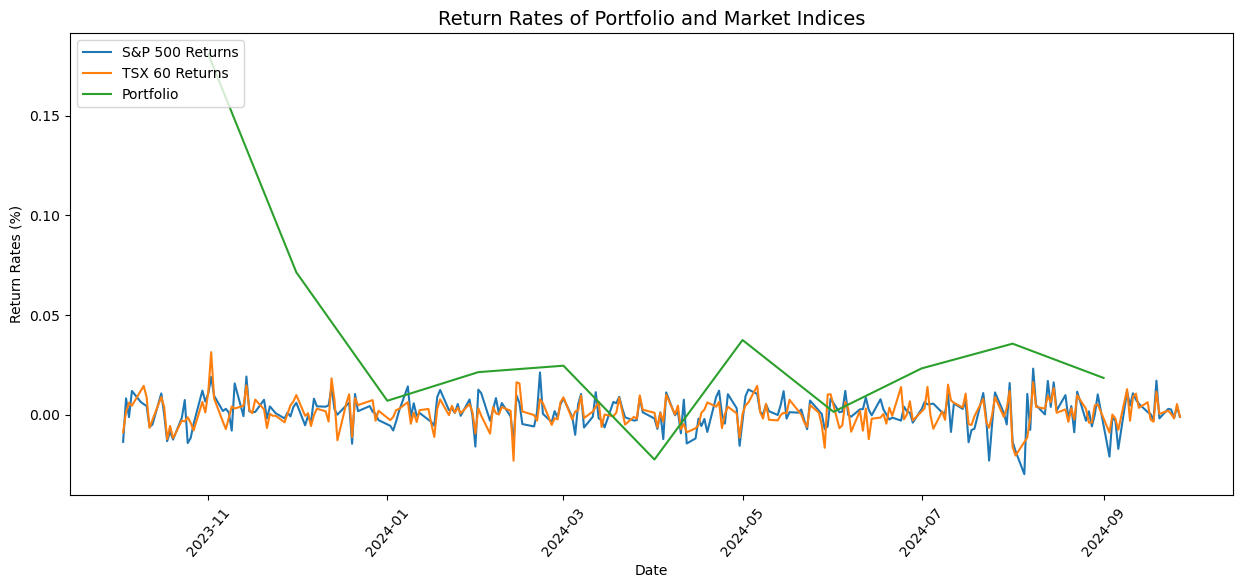

In [21]:
finallist = []
for stock, weight in weights.items():
    finallist.append(stock)

portfolio = yf.download(finallist, interval = '1mo', start=start_date, end=end_date)["Close"]
daily_returns = portfolio.pct_change().dropna()
combined_daily_returns = (daily_returns * weightlist).sum(axis=1)
combined_daily_returns

# graphing 
plt.figure(figsize=(15, 6))
plt.xticks(rotation = 50)
plt.plot(sp500_returns, label = 'S&P 500 Returns')
plt.plot(tsx60_returns, label = 'TSX 60 Returns')
plt.plot(combined_daily_returns, label = 'Portfolio')
plt.ylabel("Return Rates (%)")
plt.xlabel("Date")

plt.title("Return Rates of Portfolio and Market Indices", fontsize=14)
plt.legend(loc="upper left", fontsize=10)  